# DAC tests

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/dac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa
import torch
import dacsound
import dac

import utils
from audiotools import AudioSignal

2025-06-29 18:01:38.255789: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 18:01:38.427381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-29 18:01:38.458328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-29 18:01:38.471956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-29 18:01:38.680448: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import test_signals

tests = {}

for name, obj in vars(test_signals).items():
    if callable(obj):
        tests[name] = obj

print("Available tests:")
for i, name in enumerate(tests.keys()):
    print(f"{i}: {name}")


Available tests:
0: square_slow
1: square_fast
2: square_vibrato
3: saw_noise
4: sines_noise
5: filter_saw
6: triangle_clip
7: fm_amplitude
8: fm_frequency
9: delay_noise
10: delay_saw
11: reverb_noise
12: reverb_saw
13: get_tests


In [4]:
SAMPLE_RATE = 44100
CURRENT_TEST = 11
SMALL = True

Running test: reverb_noise


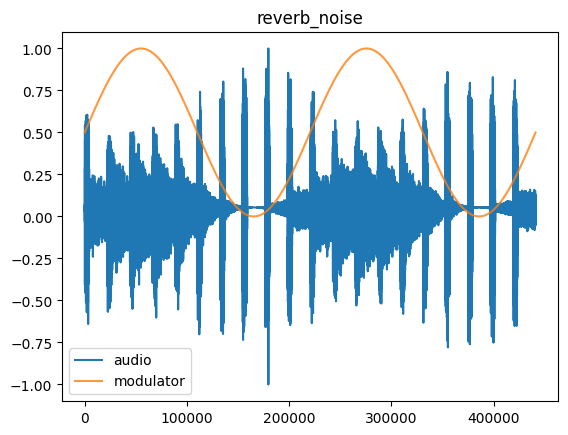

In [5]:
test = tests[list(tests.keys())[CURRENT_TEST]]
print(f"Running test: {test.__name__}")
test_name = test.__name__
audio, modulator = test()

plt.plot(audio, label='audio')
modulator = utils.norm(synth.stretch_array(modulator, len(audio)))
plt.plot(modulator, alpha=0.8, label='modulator')
plt.title(test.__name__)
plt.legend()

plt.show()

display(Audio(audio, rate=SAMPLE_RATE))

/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


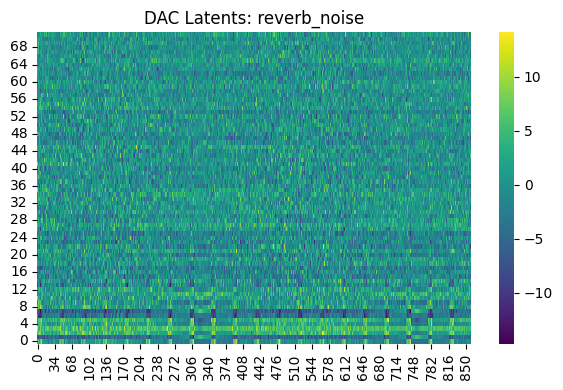

Latents shape: (72, 862)
Reconstructed audio:


In [6]:
device = torch.device('cpu') # or 'cuda'
GENERATE_LATENTS = False

model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path)
model.to(device);
model.eval();

dac_audio = dacsound.DACSound(model, audio, SAMPLE_RATE)
latents = dac_audio.latents.cpu().numpy()[0,:,:]
utils.plot_heatmap(latents, title="DAC Latents: "+test_name, small=SMALL)

print(f"Latents shape: {latents.shape}")

reconstructed = dac_audio.decode()
print(f"Reconstructed audio:")
display(Audio(reconstructed, rate=SAMPLE_RATE))


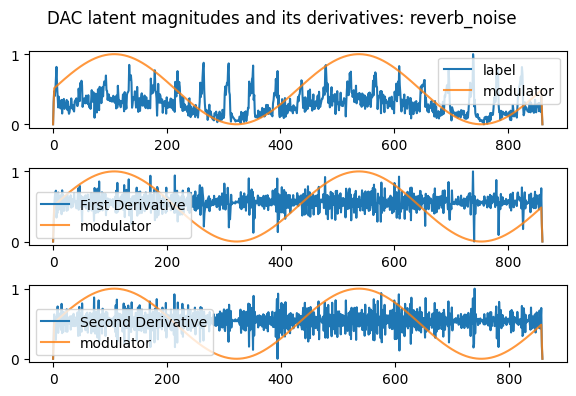

In [7]:
energy = np.linalg.norm(latents, axis=0)
d_energy = np.diff(energy)
dd_energy = np.diff(d_energy)

utils.plot_with_derivatives(
    energy,
    d_energy,
    dd_energy,
    modulator,
    title="DAC latent magnitudes and its derivatives: "+test_name,
    small=SMALL
)

max_indices: [41 30 48 35 37 18  5 17 24 22]


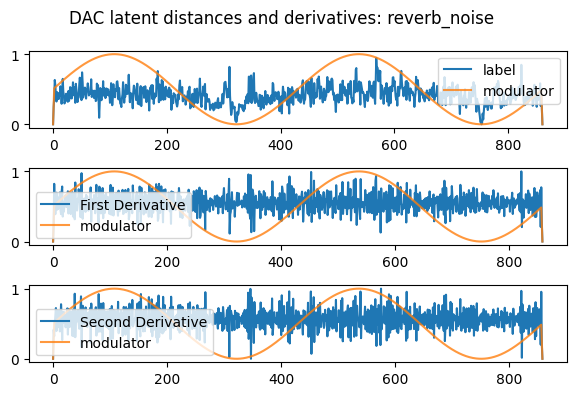

In [8]:
distances = utils.distances(latents, top_n=10)
d_distances = np.diff(distances)
dd_distances = np.diff(d_distances)

utils.plot_with_derivatives(
    distances,
    d_distances,
    dd_distances,
    modulator,
    title="DAC latent distances and derivatives: "+test_name,
    small=SMALL
)

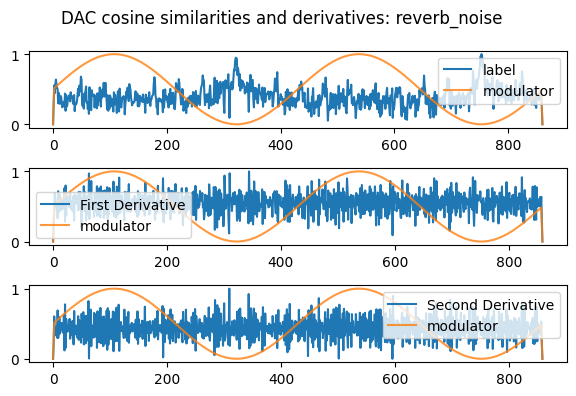

In [9]:
similarities = utils.cosine_similarity(latents)
d_similarities = np.diff(similarities)
dd_similarities = np.diff(d_similarities)

utils.plot_with_derivatives(
    similarities,
    d_similarities,
    dd_similarities,
    modulator,
    title="DAC cosine similarities and derivatives: "+test_name,
    small=SMALL
)